# Лекция 11. Разреженные матрицы

## План на сегодняшнюю лекцию

- Разреженные матрицы и форматы их представления
- Быстрая реализация умножения разреженной матрицы на вектор 

## Разреженные матрицы

- Ограничением в решении задач линейной алгебры с плотными матрицами является память, требуемая для хранения плотных матриц, $N^2$ элементов.

- Разреженные матрицы, где большинство элементов нулевые позволяют по крайней мере хранить их в памяти.

- Основные вопросы: можем ли мы решать следующие задачи для разреженных матриц?
    - решение линейных систем
    - вычисление собственных значений и собственных векторов
    - вычисление матричных функций

## Приложения разреженных матриц

Разреженные матрицы возникают в следующих областях:

- математическое моделирование и решение уравнений в частных производных
- обработка графов, например анализ социальных сетей
- рекомендательные системы
- в целом там, где отношения между объектами "разрежены".

### Разреженные матрицы помогают в вычислительной теории графов 

- Графы представляют в виде матриц смежности, которые чаще всего разрежены
- Численное решение задач теории графов сводится к операциям с этими разреженными матрицами
    - Кластеризация графа и выделение сообществ
    - Ранжирование
    - Случайные блуждатели
    - И другие....
- Пример: возможно, самый большой доступный граф гиперссылок содержит 3.5 миллиарда веб-страниц и 128 миллиардов гиперссылок, больше подробностей см. [тут](http://webdatacommons.org/hyperlinkgraph/) 
- Различные графы среднего размера для тестирования ваших алгоритмов доступны в [Stanford Large Network Dataset Collection](https://snap.stanford.edu/data/)

### Florida sparse matrix collection

- Большое количество разреженных матриц из различных приложений вы можете найти в [Florida sparse matrix collection](http://www.cise.ufl.edu/research/sparse/matrices/).

In [1]:
from IPython.display import IFrame
IFrame('http://yifanhu.net/GALLERY/GRAPHS/search.html', 500, 500)

### Разреженные матрицы и глубокое обучение

- DNN имеют очень много параметров
- Некоторые из них могут быть избыточными
- Как уменьшить число параметров без серьёзной потери в точности?
- [Sparse variational dropout method](https://github.com/ars-ashuha/variational-dropout-sparsifies-dnn) даёт существенно разреженные фильтры в DNN почти без потери точности!
- [Lottery ticket hypothesis](https://arxiv.org/pdf/1803.03635.pdf) также рассматривает возможность спрасификации нейросети без снижения точности прогноза

## Построение разреженных матриц

- Мы можем генерировать разреженные матрицы с помощью пакета ```scipy.sparse```

- Можно задать матрицы очень большого размера

Полезные функции при создании разреженных матриц:
- для созданий диагональной матрицы с заданными диагоналями ```spdiags```
- Кронекерово произведение (определение будет далее) разреженных матриц ```kron```
- также арифметические операции для разреженных матриц перегружены

### Кронекерово произведение

Для матриц $A\in\mathbb{R}^{n\times m}$ и $B\in\mathbb{R}^{l\times k}$ Кронекерово произведение определяется как блочная матрица следующего вида

$$
   A\otimes B = \begin{bmatrix}a_{11}B & \dots & a_{1m}B \\ \vdots & \ddots & \vdots \\ a_{n1}B & \dots & a_{nm}B\end{bmatrix}\in\mathbb{R}^{nl\times mk}.
$$

Основные свойства:
- билинейность
- $(A\otimes B) (C\otimes D) = AC \otimes BD$
- Пусть $\mathrm{vec}(X)$ оператор векторизации матрицы по столбцам. Тогда 
$\mathrm{vec}(AXB) = (B^T \otimes A) \mathrm{vec}(X).$

4992 1048576 (1024, 1024)


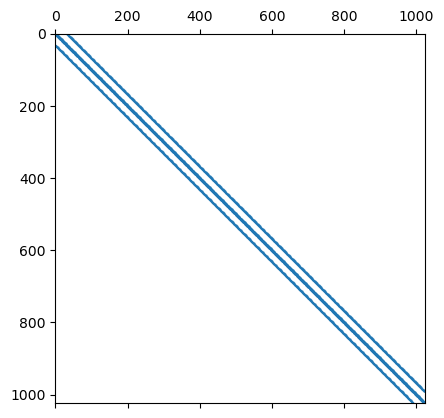

In [2]:
import numpy as np
import scipy as sp
import scipy.sparse
from scipy.sparse import csc_matrix, csr_matrix
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.sparse.linalg
%matplotlib inline
n = 32
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csc_matrix(A)
plt.spy(A, aspect='equal', marker='.', markersize=1)
print(A.nnz, np.prod(A.shape), A.shape)

### Шаблон разреженности

- Команда ```spy``` рисует шаблон разреженности данной матрицы: пиксель $(i, j)$ отображается на рисунке, если соответствующий элемент матрицы ненулевой.

- Шаблон разреженности действительно очень важен для понимания сложности алгоритмов линейной алгебры для разреженных матриц.  

- Зачастую шаблона разреженности достаточно для анализа того, насколько "сложно" работать с этой матрицей.

### Определение разреженных матриц

- Разреженные матрицы – это матрицы, такие что количество ненулевых элементов в них существенно меньше общего числа элементов в матрице. 

- Из-за этого вы можете выполнять базовые операции линейной алгебры (прежде всего решать линейные системы) гораздо быстрее по сравнению с использованием плотных матриц.

## Что нам необходимо, чтобы увидеть, как это работает

- **Вопрос 1:** Как хранить разреженные матрицы в памяти?

- **Вопрос 2:** Как умножить разреженную матрицу на вектор быстро?

- **Вопрос 3:** Как быстро решать линейные системы с разреженными матрицами?

### Хранение разреженных матриц

Существет много форматов хранения разреженных матриц, наиболее важные:

- COO (координатный формат)
- LIL (список списков)
- CSR (compressed sparse row)
- CSC (compressed sparse column)
- блочные варианты

В ```scipy``` представлены конструкторы для каждого из этих форматов, например

```scipy.sparse.lil_matrix(A)```.

#### Координатный формат (COO)

- Простейший формат хранения разреженной матрицы – координатный. 
- В этом формате разреженная матрица – это набор индексов и значений в этих индексах.

```python
i, j, val
```

где ```i, j``` массивы индексов, ```val``` массив элементов матрицы. <br>

- Таким образом, нам нужно хранить $3\cdot$**nnz** элементов, где **nnz** обозначает число ненулевых элементов в матрице.

**Q:** Что хорошего и что плохого в использовании такого формата?

#### Основные недостатки

- Он неоптимален по памяти (почему?)
- Он неоптимален для умножения матрицы на вектор (почему?)
- Он неоптимален для удаления элемента (почему?)

Первые два недостатка решены в формате CSR.

#### Compressed sparse row (CSR)

В формате CSR матрица хранится также с помощью трёх массивов, но других:

```python
ia, ja, sa
```

где:

- **ia** (начало строк) массив целых чисел длины $n+1$ 
- **ja** (индексы столбцов) массив целых чисел длины **nnz** 
-  **sa** (элементы матрицы) массив действительных чисел длины **nnz**

<img src="https://www.karlrupp.net/wp-content/uploads/2016/02/csr_storage_sparse_marix.png" width=60% />

Итак, всего необходимо хранить $2\cdot{\bf nnz} + n+1$ элементов.

### Разреженные матрицы в PyTorch, Tensorflow и JAX

- PyTorch поддерживает разреженные матрицы в формате COO
- Неполная поддержка вычисления градиентов в операциях с такими матрицами, список и обсуждение см. [тут](https://github.com/pytorch/pytorch/issues/9674)
- Tensorflow также поддерживает разреженные матрицы в COO формате
- Список поддерживаемых операций приведён [здесь](https://www.tensorflow.org/api_docs/python/tf/sparse), поддержка вычисления градиентов ограничена
- JAX также [экспериментально поддерживает](https://jax.readthedocs.io/en/latest/jax.experimental.sparse.html) некоторые разреженные операции для COO матриц

### CSR формат позволяет быстро умножить разреженную матрицу на вектор (SpMV)

```python

   for i in range(n):
        
        for k in range(ia[i]:ia[i+1]):
            
            y[i] += sa[k] * x[ja[k]]
```

In [3]:
import numpy as np
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
from scipy.sparse import csc_matrix, csr_matrix, coo_matrix
import matplotlib.pyplot as plt
%matplotlib inline
n = 2000
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csr_matrix(A)
# Anp = A.toarray()
rhs = np.random.randn(n * n)
B = coo_matrix(A)
%timeit A @ rhs
%timeit B.tocsr() @ rhs
# %timeit Anp @ rhs

17.3 ms ± 95.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
174 ms ± 3.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Видно, что **CSR** быстрее, и чем менее структурирован шаблон разреженности, тем выше выигрыш в скорости.

### Разреженные матрицы и эффективность

- Использование разреженных матриц приводит к уменьшению сложности
- Но они не очень подходят для параллельных/GPU реализаций 
- Они не показывают максимальную эффективность из-за случайного доступа к данным.   

### Случайный доступ к данным и промахи в обращении к кешу

- Сначала все элементы матрицы и вектора хранятся в оперативной памяти (RAM – Random Access Memory)
- После этого CPU берёт данные из кеша, обрабатывает их и возвращает результат снова в кеш
- Если CPU требуются данные, которых ещё нет в кеше, это называется промах в обращении к кешу (cache miss)
- Если случается промах в обращении к кешу, необходимые данные перемещаются из оперативной памяти в кеш

**Q**: что если в кеше нет свободного места?


- Чем больше промахов в обращении к кешу, тем медленнее выполняются вычисления

#### Умножение матрицы в CSR формате на вектор

```python

   for i in range(n):
        
        for k in range(ia[i]:ia[i+1]):
            
            y[i] += sa[k] * x[ja[k]]
            
```

- Какая часть операций приводит к промахам в обращении к кешу?
- Как эту проблему можно решить?

### Переупорядочивание уменьшает количество промахов в обращении к кешу

- Если ```ja``` хранит последовательно элементы, тогда они могут быть перемещены в кеш одновременно и количество промахов в обращении к кешу уменьшится
- Так происходит, когда разреженная матрица является **ленточной** или хотя бы блочно-диагональной
- Мы можем превратить данную разреженную матрицу в ленточную или блочно-диагональную с помощью *перестановок* 

- Пусть $P$ матрица перестановок строк матрицы и $Q$ матрица перестановок столбцов матрицы
- $A_1 = PAQ$ – матрица с шириной ленты меньшей, чем у матрицы $A$
- $y = Ax \to \tilde{y} = A_1 \tilde{x}$, где $\tilde{x} = Q^{\top}x$ и $\tilde{y} = Py$
- [Separated block diagonal form](http://albert-jan.yzelman.net/PDFs/yzelman09-rev.pdf) призван минимизировать количество промахов в обращении к кешу
- Он также может быть расширен на двумерный случай, где разделяются не только строки, но и столбцы

## Методы решения линейных систем с разреженными матрицами

- Прямые методы
    - LU разложение
    - Различные методы переупорядочивания для минимизации заполнения факторов
- Крыловские методы

32.6 ms ± 2.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.31 s ± 252 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


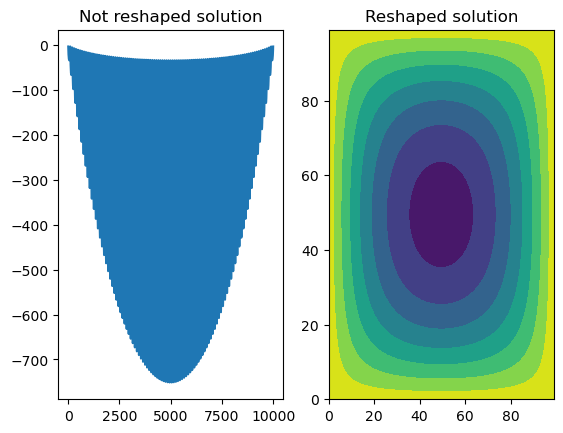

In [4]:
n = 100
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csr_matrix(A)
rhs = np.ones(n * n)
sol = sp.sparse.linalg.spsolve(A, rhs)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(sol)
ax1.set_title('Not reshaped solution')
ax2.contourf(sol.reshape((n, n), order='f'))
ax2.set_title('Reshaped solution')

Anp = A.toarray()
%timeit sp.sparse.linalg.spsolve(A, rhs)
%timeit np.linalg.solve(Anp, rhs)

## LU разложение разреженной матрицы

- Почему разреженная линейная система может быть решена быстрее, чем плотная? С помощью какого метода? 

- В LU разложении матрицы $A$ факторы $L$ и $U$ могут быть также разреженными:

$$A = L U$$

- А решение линейной системы с разреженной треугольной матрицей может быть вычислено очень быстро.  

<font color='red'> Заметим, что обратная матрица от разреженной матрицы НЕ разрежена! </font>


In [5]:
n = 7
ex = np.ones(n);
a = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
b = np.array(np.linalg.inv(a.toarray()))
print(a.toarray())
print(b)

[[-2.  1.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  1. -2.]]
[[-0.875 -0.75  -0.625 -0.5   -0.375 -0.25  -0.125]
 [-0.75  -1.5   -1.25  -1.    -0.75  -0.5   -0.25 ]
 [-0.625 -1.25  -1.875 -1.5   -1.125 -0.75  -0.375]
 [-0.5   -1.    -1.5   -2.    -1.5   -1.    -0.5  ]
 [-0.375 -0.75  -1.125 -1.5   -1.875 -1.25  -0.625]
 [-0.25  -0.5   -0.75  -1.    -1.25  -1.5   -0.75 ]
 [-0.125 -0.25  -0.375 -0.5   -0.625 -0.75  -0.875]]


## А факторы...

- $L$ и $U$ обычно разрежены
- В случае трёхдиагональной матрицы они даже бидиагональны!

[0 1 2 3 4 5 6] [0 1 2 3 4 5 6]


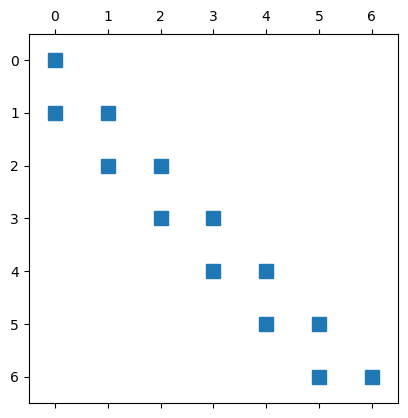

In [6]:
from scipy.sparse.linalg import splu
T = splu(a.tocsc(), permc_spec="NATURAL")
plt.spy(T.L)
print(T.perm_r, T.perm_c)

Отметим, что ```splu``` со значением параметра ```permc_spec``` по умолчанию даёт перестановку, которая не даёт бидиагональные факторы:

[0 1 2 3 5 4 6] [0 1 2 3 5 4 6]


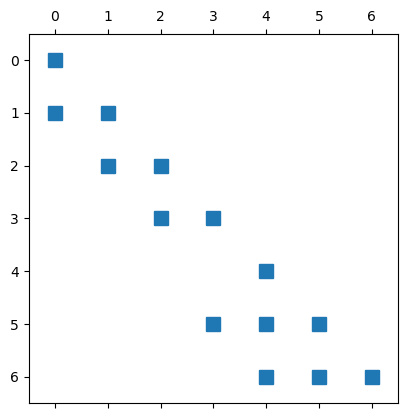

In [7]:
from scipy.sparse.linalg import splu
T = splu(a.tocsc())
plt.spy(T.L)
print(T.perm_c, T.perm_r)

## Двумерный случай

В двумерном случае всё гораздо хуже:

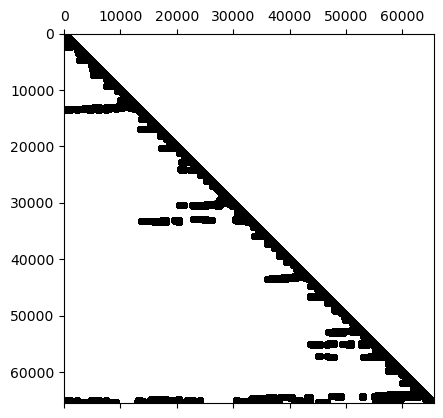

In [8]:
n = 256
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csc_matrix(A)
T = scipy.sparse.linalg.splu(A)
plt.spy(T.L, marker='.', color='k', markersize=8)

## Особенности реализации LU разложения для разреженных матриц

- В случае плотной матрицы перестановки обеспечивали устойчивость вычислений и отсутствие деления на маленькие по модулю числа
- В разреженном случае к этому добавляется требование разреженности факторов
- Эти два условия часто бывают противоречивыми, поэтому в параметрах функции ```scipy.sparse.linalg.splu``` присуствуют различные стратегии перестановок - параметр ```permc_spec```

## Главное в сегодняшней лекции

- Разреженные матрицы, приложения и форматы их хранения
- Эффективные способы умножения разреженной матрицы на вектор
- LU разложение разреженной матрицы: заполнение и перестановки строк